# Date: 01.08.2020
# MovieLens: Full Training
# Coder: Maksym Chernozhukov

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from time import time
from tqdm.auto import tqdm
from datetime import datetime

%matplotlib notebook
%run dataLoader.ipynb
warnings.filterwarnings("ignore")

epoch = []
valid = []
train = []
mae_valid = []
tic_all = time()
path_results = './datasets/main/results/'

seed = int(time())
np.random.seed(seed)


# load data
tr, vr = loadData('./datasets/main/ml-1M.dat', valfrac=0.1, delimiter='::', seed=seed, transpose=True)
# tr, vr = loadData('./datasets/main/ml-100K.dat', valfrac=0.25, delimiter=':', seed=seed, transpose=True)

tm = np.greater(tr, 1e-12).astype('float32')  # masks indicating non-zero entries (0, 1 matrix)
vm = np.greater(vr, 1e-12).astype('float32')

n_m = tr.shape[0]  # number of movies
n_u = tr.shape[1]  # number of users (may be switched depending on 'transpose' in loadData)

# Set hyper-parameters
n_hid = 500          # hidden units

lambda_2 = 60.       # L2
lambda_s = 0.013     # sparsity regularization strength

n_layers = 2
output_every = 50     # evaluate performance on test set; breaks l-bfgs loop
n_epoch = n_layers * 10 * output_every   # 1000 (20)
verbose_bfgs = True   # show details of BFGS
use_gpu = False
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''


# Input placeholders
R = tf.placeholder("float", [None, n_u])


# define network functions
def kernel(u, v):
    """
    Sparsifying kernel function
    Make super weights

    :param u: input vectors [n_in, 1, n_dim]
    :param v: output vectors [1, n_hid, n_dim]
    :return: input to output connection matrix
    """
    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)    # 0 or higher
    return hat


def kernel_layer(x, n_hid=500, n_dim=5, activation=tf.nn.sigmoid, lambda_s=lambda_s, lambda_2=lambda_2, name=''):
    """
    a kernel sparsified layer

    :param x: input [batch, channels] = [rows, columns]
    :param n_hid: number of hidden units
    :param n_dim: number of dimensions to embed for kernelization
    :param activation: output activation
    :param name: layer name for scoping
    :return: layer output, regularization term
    """

    # define variables
    with tf.variable_scope(name):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    # compute sparsifying kernel
    # as u and v move further from each other for some given pair of neurons, their connection
    # decreases in strength and eventually goes to zero.
    w_hat = kernel(u, v)

    # compute regularization terms
    sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])

    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    # compute output
    W_eff = W * w_hat
    y = tf.matmul(x, W_eff) + b
    y = activation(y)
    return y, sparse_reg_term + l2_reg_term


# Instantiate network
y = R
reg_losses = None

# 2 hidden layers
for i in range(n_layers):                                                        
    y, reg_loss = kernel_layer(y, n_hid, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss

# output layer
prediction, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out') 
reg_losses = reg_losses + reg_loss

# Compute loss (symbolic)
diff = tm*(R - prediction)
sqE = tf.nn.l2_loss(diff)
loss = sqE + reg_losses

# Instantiate L-BFGS Optimizer
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': output_every,
                                                                  'disp': verbose_bfgs,
                                                                  'maxcor': 10},
                                                   method='L-BFGS-B')

# Training and validation loop
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in tqdm( range( int(n_epoch / output_every) ), unit='epoch' ):
        optimizer.minimize(sess, feed_dict={R: tr})   # do maxiter optimization steps
        pre = sess.run(prediction, feed_dict={R: tr}) # predict ratings

        RMSE_valid = np.sqrt((vm * (np.clip(pre, 1., 5.) - vr) ** 2).sum() / vm.sum()) # compute validation error
        RMSE_train = np.sqrt((tm * (np.clip(pre, 1., 5.) - tr) ** 2).sum() / tm.sum()) # compute train error
        MAE_valid = abs(vm * (np.clip(pre, 1., 5.) - vr)).sum() / vm.sum()             # compute validation error MAE

        epoch.append(i)                 # epoch list [0..19]
        valid.append(RMSE_valid)        # valid list with 20 valid RMSE
        train.append(RMSE_train)        # train list with 20 train RMSE
        mae_valid.append(MAE_valid)     # valid list with 20 valid MAE

        print('-' * 85)
        print('\n\tEpoch: {0}\t Validation RMSE: {1:0.6f}\t Train RMSE: {2:0.6f}\n'.format(i, RMSE_valid, RMSE_train))
        print('-' * 85)

    with open(path_results + 'final_filter.txt', 'a') as file:
        file.write('\n\n')
        for i in range(len(epoch)):
            file.write('{0}\t{1}\t{2}\t{3}\t{4}\n'.format('1.7F_WFin', epoch[i], valid[i], mae_valid[i], train[i]))
        file.write('Trained: {0}\tSeed: {1}\tRMSE: {2}\tMAE: {3}'.format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), seed, min(valid), min(mae_valid)))
        file.close()
        
    with open(path_results + 'train_valid.txt', 'a') as file:
        file.write('\n\n')
        for i in range(len(epoch)):
            file.write('{0}\t{1}\t{2}\t{3}\n'.format(epoch[i], valid[i], mae_valid[i], train[i]))
        file.write('Trained: {0}\tSeed: {1}'.format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), seed))
        file.close()

    with open(path_results + 'summary_ml1m.txt', 'a') as file:
        for a in sys.argv[1:]:
            file.write(a + ' ')
        file.write('\tRMSE: {0:0.6f}\tMAE: {1:0.6f}\tTr: {2:0.6f}\tTm: {3}\n'.format(min(valid), min(mae_valid), min(train), seed))
        file.close()

print('\nA model was trained in: {:0.2f} min!\n'.format((time() - tic_all) / 60.0))


C:\Users\Maksym\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Maksym\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Maksym\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Maksym\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

reading data...

data read in: 9.03 seconds!
loaded dense data matrix

All data preprocessed: 10.87 seconds!

------------------------------------------------------------------------

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 443647.812500
  Number of iterations: 50
  Number of functions evaluations: 54
-------------------------------------------------------------------------------------

	Epoch: 0	 Validation RMSE: 0.886414	 Train RMSE: 0.873201

-------------------------------------------------------------------------------------
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 381597.250000
  Number of iterations: 50
  Number of functions evaluations: 53
-------------------------------------------------------------------------------------

	Epoch: 1	 Validation RMSE: 0.854221	 Train RMSE: 0.818384

-------------------------------------------------------------------------------------
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Object

-------------------------------------------------------------------------------------

	Epoch: 18	 Validation RMSE: 0.823996	 Train RMSE: 0.686094

-------------------------------------------------------------------------------------
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 308669.437500
  Number of iterations: 50
  Number of functions evaluations: 54
-------------------------------------------------------------------------------------

	Epoch: 19	 Validation RMSE: 0.824030	 Train RMSE: 0.684179

-------------------------------------------------------------------------------------


A model was trained in: 43.97 min!



In [2]:
# Baseline    RMSE: 0.822971165     36.18 min!

# Visualize Estimations

In [3]:
stop_epoch = [i for i in range(len(valid)) if valid[i] == min(valid)][0]
print('Epoch: {0}\tRMSE: {1:0.6f}\t\tMAE: {2:0.6f}'.format(stop_epoch, min(valid), min(mae_valid) ) )

Epoch: 15	RMSE: 0.823453		MAE: 0.642748


In [4]:
# Epoch: 13    RMSE: 0.823178    MAE: 0.642512   1.9   float
# Epoch: 13    RMSE: 0.823702    MAE: 0.642767   1.9   float
# Epoch: 15    RMSE: 0.823754    MAE: 0.642706   1.9   float

# With fading
# Epoch: 15    RMSE: 0.823340    MAE: 0.642559   1.7F   float
# Epoch: 13    RMSE: 0.823691    MAE: 0.642694   1.7F   float
# Epoch: 16    RMSE: 0.823707    MAE: 0.643009   1.7F   float

# With fading
# Epoch: 15    RMSE: 0.823949    MAE: 0.643019   1.7F_W   float
# Epoch: 15    RMSE: 0.823537    MAE: 0.642705   1.7F_W   float
# Epoch: 15    RMSE: 0.823182    MAE: 0.642330   1.7F_W   float
# Epoch: 15    RMSE: 0.823182    MAE: 0.642330   1.7F_W   float
# Epoch: 15    RMSE: 0.823453    MAE: 0.642748
# Only prediction
# Epoch: 16    RMSE: 0.823531    MAE: 0.642316   1.7N  float
# Epoch: 13    RMSE: 0.823146    MAE: 0.642297   1.8N  float

# Prediction with Weight
# Epoch: 18    RMSE: 0.823997    MAE: 0.642999   1.7W  float
# Epoch: 15    RMSE: 0.823827    MAE: 0.642729   1.8W  float

# Epoch: 14    RMSE: 0.823114    MAE: 0.642145      DL prediction with weight int
# Epoch: 15    RMSE: 0.823131    MAE: 0.642038      DL prediction with weight int

<IPython.core.display.Javascript object>


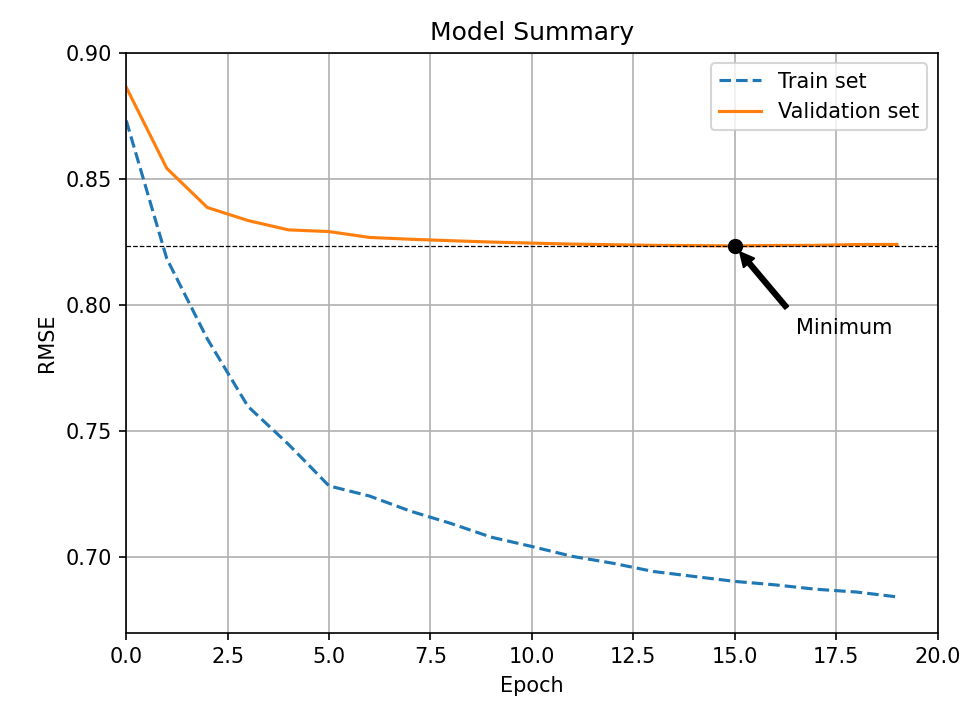

In [5]:
# Create a Figure with Axes
fig, ax = plt.subplots()

# Draw: Two lines, Minima point, Horizontal line and Annotation
ax.plot(epoch, train, linestyle='--', label='Train set')
ax.plot(epoch, valid, label='Validation set')

ax.scatter(stop_epoch, min(valid), s=40, color='k', zorder=2.5)
ax.axhline(y=min(valid), color='k', linestyle='--', linewidth=0.6)

ax.annotate('Minimum', xy=(stop_epoch, min(valid)), xytext=(stop_epoch+1.5, min(valid)-0.035),
            arrowprops=dict(facecolor='black', width=2, headwidth=6.5, headlength=6.5, shrink=0.09))

# Title and X, Y Labels
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.set_title('Model Summary')

# Some additional functions
ax.grid()
ax.legend()
fig.tight_layout()
ax.axis([0, 20, 0.67, 0.9])

# Save and show figure
fig.savefig('./datasets/main/images/1. Train vs Valid.pdf')
fig.savefig('./datasets/main/images/1. Train vs Valid TEST.pdf')
fig.show()

### Save file

In [6]:
from numpy import save, load

predicted_matrix = pre.T

save('predicted_matrix_1M.npy', predicted_matrix)
final_matrix_load = load('predicted_matrix_1M.npy')

print(final_matrix_load)
print(np.shape(predicted_matrix), (final_matrix_load == predicted_matrix).all())